## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [11]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

### Data Load

In [12]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_16.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_16.csv')

DI_train = pd.read_csv('../data/DI_train_dataset.csv')
DI_test = pd.read_csv('../data/DI_test_dataset.csv')

In [13]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [21]:
DI_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               6290 non-null   object 
 1   시술_당시_나이               6290 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  6290 non-null   object 
 3   배란_자극_여부               6290 non-null   int64  
 4   남성_주_불임_원인             6290 non-null   int64  
 5   남성_부_불임_원인             6290 non-null   int64  
 6   여성_주_불임_원인             6290 non-null   int64  
 7   여성_부_불임_원인             6290 non-null   int64  
 8   부부_주_불임_원인             6290 non-null   int64  
 9   부부_부_불임_원인             6290 non-null   int64  
 10  불명확_불임_원인              6290 non-null   int64  
 11  불임_원인_-_난관_질환          6290 non-null   int64  
 12  불임_원인_-_남성_요인          6290 non-null   int64  
 13  불임_원인_-_배란_장애          6290 non-null   int64  
 14  불임_원인_-_자궁내막증          6290 non-null   int64  
 15  불임_원

In [14]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]


In [15]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [16]:
# # 모든 범주형 변수를 문자열로 변환
# IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
# DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
# IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
# DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# # OrdinalEncoder를 사용하여 범주형 변수 인코딩
# IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
# DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
# IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
# DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [17]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

In [18]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 범주형 변수 인덱스
cat_feature_indices = [IVF_X_train.columns.get_loc(col) for col in IVF_categorical_columns]

# 목적 함수 정의
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'logging_level': 'Silent'
    }

    model = CatBoostClassifier(cat_features=cat_feature_indices, **param)
    model.fit(IVF_X_train, IVF_y_train, eval_set=[(IVF_X_test, IVF_y_test)], verbose=False)
    
    y_pred_proba = model.predict_proba(IVF_X_test)[:, 1]
    auc = roc_auc_score(IVF_y_test, y_pred_proba)
    
    return auc

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적의 하이퍼파라미터로 모델 학습
best_params = trial.params
IVF_model = CatBoostClassifier(cat_features=cat_feature_indices, **best_params)
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

[I 2025-02-04 11:00:07,707] A new study created in memory with name: no-name-204b66d6-c870-4599-b393-7586bcd02f29


[W 2025-02-04 11:00:09,713] Trial 0 failed with parameters: {'iterations': 2942, 'depth': 6, 'learning_rate': 0.0026995636830080445, 'l2_leaf_reg': 0.004055667098373747, 'bagging_temperature': 0.6175028311109455, 'random_strength': 8.822985894681294, 'scale_pos_weight': 7.534192828739862, 'border_count': 53} because of the following error: CatBoostError('Invalid type for cat_feature[non-default value idx=152145,feature_idx=64]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.').
Traceback (most recent call last):
  File "_catboost.pyx", line 2449, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 1967, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: nan

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\optuna\study\

CatBoostError: Invalid type for cat_feature[non-default value idx=152145,feature_idx=64]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

---


--- Model Performance ---
Model Accuracy: 0.7458959029013617
Model F1 Score: 0.2033600802407222
Model AUC: 0.7405188588361808


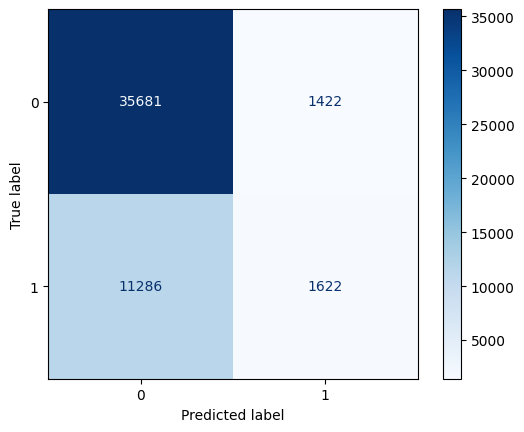

In [36]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=1258,
    num_leaves=923,
    max_depth=5,
    learning_rate=0.024413717866391526,
    min_child_samples=105,
    subsample=0.4890106069104924,
    colsample_bytree=0.4494069713807123,
    reg_alpha=3.0197481977859035,
    reg_lambda=0.4793565720612017,
    min_split_gain=0.29685405151668676,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
    )

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7105176933158585


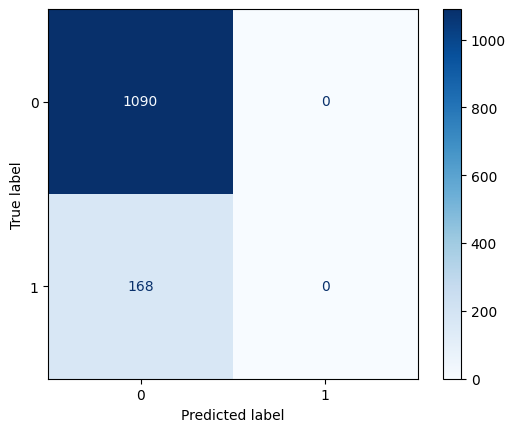

In [37]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=2443,
    num_leaves=280,
    max_depth=149,
    learning_rate=0.061743249432816755,
    min_child_samples=176,
    subsample=0.9103802819067428,
    colsample_bytree=0.6636673663468106,
    reg_alpha=0.01173260476029451,
    reg_lambda=59.000778013447324,
    min_split_gain=1.1755604684312402,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7488540833642162
Model F1 Score: 0.2012406947890819
Model AUC: 0.742169537176292


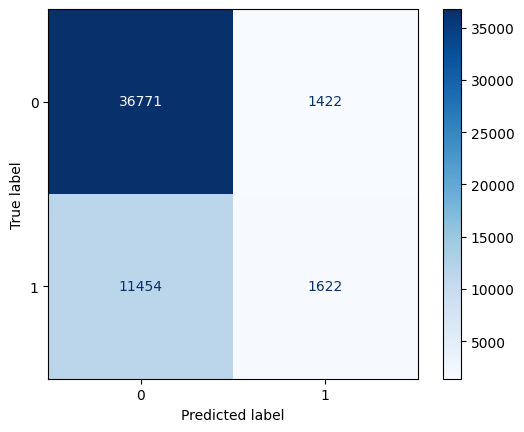

In [38]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [39]:
# 모델 구축
# IVF_model = CatBoostClassifier(
#     iterations=680,
#     depth=10,
#     learning_rate=0.01,
#     random_seed=42,
#     verbose=0
# )

# DI_model = CatBoostClassifier(
#     iterations=500,
#     depth=10,
#     learning_rate=0.01,
#     random_seed=42,
#     verbose=0
# )

# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [40]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('./code16_submit.csv', index=False, encoding='utf-8')

.